In [37]:
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import when
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from IPython.display import display

import matrix_factorization
import importlib
importlib.reload(matrix_factorization)
from matrix_factorization import *

In [2]:
#.config("spark.executor.memoryOverhead", "64g")\
spark = SparkSession\
    .builder\
    .appName("matrix-factorization")\
    .config("spark.executor.heartbeatInterval", "60s")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.driver.maxResultSize", "64g")\
    .config("spark.sql.crossJoin.enabled", True)\
    .getOrCreate()
sc = spark.sparkContext

In [33]:
def to_pd(df, take=0):
    if take > 0:
        return pd.DataFrame(df.take(take), columns=df.columns)
    return pd.DataFrame(df.collect(), columns=df.columns)

In [38]:
mf = matrix_factorization(spark, sc)
mf.read_train("test_1000/train.tsv", is_preprocessed=True)
mf.read_test("test_1000/test.tsv", is_preprocessed=True)

In [52]:
model, predictions, rmse = mf.train_evaluate(mf.train, mf.test, "like", alpha=10.0)

Root-mean-square error = 0.6295443133971624


In [53]:
predictions.orderBy(F.col("prediction")).show()

+----+-----+-------+--------------------+--------------+----------------------+-------------+
|like|reply|retweet|retweet_with_comment|tweet_id_index|engaging_user_id_index|   prediction|
+----+-----+-------+--------------------+--------------+----------------------+-------------+
|   0|    0|      0|                   0|      39242055|               5430254|-0.0015333588|
|   1|    0|      0|                   0|      24906891|              17949469|-0.0010719532|
|   1|    0|      0|                   0|      42438594|               1378566|-2.8725952E-4|
|   0|    0|      0|                   0|      12920656|               2571973| -5.200132E-5|
|   0|    0|      0|                   0|       9168197|               6007640|-2.7330727E-6|
|   0|    0|      0|                   0|      25478716|                654055| -2.394495E-6|
|   0|    0|      0|                   0|      38105035|              10622989|-2.5292042E-7|
|   0|    0|      0|                   0|      11265623|    

In [54]:
predictions.orderBy(F.col("prediction").desc()).show()

+----+-----+-------+--------------------+--------------+----------------------+------------+
|like|reply|retweet|retweet_with_comment|tweet_id_index|engaging_user_id_index|  prediction|
+----+-----+-------+--------------------+--------------+----------------------+------------+
|   1|    0|      0|                   0|       1650757|               3589078|    0.669931|
|   1|    0|      0|                   0|      21919139|               9461293|   0.6505501|
|   1|    0|      0|                   0|       3313753|                372718|  0.32617986|
|   1|    0|      0|                   0|      11210478|               4571275|  0.31241173|
|   1|    0|      0|                   0|      10735098|               6843623|  0.24108389|
|   1|    0|      1|                   0|      23149261|               9547160|  0.20245434|
|   1|    0|      0|                   0|      15123324|              12426495|  0.07558963|
|   1|    0|      0|                   0|      22905480|              

In [55]:
pd_df = pd.DataFrame(predictions.collect(), columns=predictions.columns)

In [56]:
normalized = (pd_df["prediction"] - pd_df["prediction"].min()) / (pd_df["prediction"].max() - pd_df["prediction"].min())

In [57]:
normalized[normalized >= 0.5].shape

(2,)

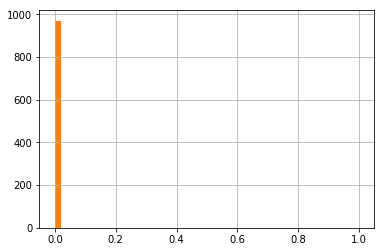

In [58]:
import matplotlib.pyplot as plt
pd_df["prediction"].hist(bins=50)
plt.savefig("../plots/lol.png")

normalized.hist(bins=50)
plt.savefig("../plots/lolnorm.png")

In [13]:
model.save("test_1000/model")

In [ ]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

# Generate top 10 movie recommendations for a specified set of users
users = df.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = df.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)